In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import copy
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import seaborn as sns
import numpy as np

## PART 1- NB Implementation

In [2]:
def sentiment_analysis(data):
    
    df = pd.read_csv(data)
    
    # 1- LOWER CASE 
    
    df_copy = copy.deepcopy(df)
    df_copy['Review']= df_copy.loc[:,'Review'].str.lower()
    
    # 2- REMOVE PUNCTIATION
    
    tokenizer = RegexpTokenizer(r"\w+")
    df_copy['Review'] = df_copy['Review'].map(tokenizer.tokenize)
    
    
    # 3- REMOVE STOP WORDS
    
    stop_words_nltk = set(stopwords.words('english'))
    
    df_copy['Review']= df_copy['Review'].apply(lambda x: [item for item in x if item not in stop_words_nltk])
    
    # 4- STEM THE WORDS
    
    wordnet_lemmatizer = WordNetLemmatizer()
    #porter = PorterStemmer()
    #lancaster=LancasterStemmer()
    #snowball = SnowballStemmer("english")
    
    #for w in all_reviews:
        #print("{0:20}{1:20}{2:20}{3:20}{4:20}".format(w,porter.stem(w),lancaster.stem(w),
                                                   # wordnet_lemmatizer.lemmatize(w, pos="v"),snowball_stem(w)))
    
    df_copy['Review_stemmed'] = df_copy['Review'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y, pos="v") 
                                                                   for y in x])
    df_copy = df_copy.drop(columns=['Review'])
    
    # 5- VECTORIZE --> First divided into test and train to prevent leakage
    
        # Split the dataset into train and test. 
    
    X_train, X_test, y_train, y_test = train_test_split(df_copy['Review_stemmed'],df_copy['Sentiment'], 
                                                        train_size=0.801,random_state=1)
    
    X_train_copy = copy.deepcopy(X_train)
    X_test_copy = copy.deepcopy(X_test)
    
    
    X_train_copy = X_train_copy.apply(lambda x: " ".join(x) )
    X_test_copy = X_test_copy.apply(lambda x: " ".join(x) )
  
    # max_features=1800 gives the best accuracy 
    
    cv = CountVectorizer(max_features=1800, stop_words='english')
    
    X_train_tf = cv.fit_transform(X_train_copy)
    
    X_test_tf = cv.transform(X_test_copy)
    
    
    # 6- MULTINOMINAL BAYES
    
    clf = MultinomialNB()
    
    clf.fit(X_train_tf, y_train)
    
    predicted = clf.predict(X_test_tf)
    
    accuracy = metrics.accuracy_score(y_test, predicted)
    
    print(f"Your accuracy is: {accuracy}")
    
    # 7- CONFUSION MATRIX
    
    cf_matrix = metrics.confusion_matrix(y_test, predicted)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='RdYlGn')
    

Your accuracy is: 0.7572463768115942


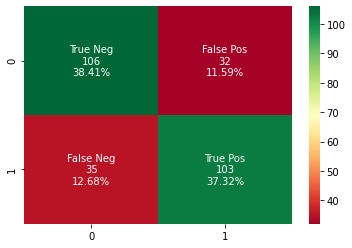

In [3]:
test = sentiment_analysis('car-reviews.csv')
test

## PART 2- Improvements



I wanted to make 2 improvements in the NB implementation:

### 1) Vectorizer

While analysing the code, I realized some words in my training data which has a high frequency but low impact. (Such as {one': 1635, 'would': 1426} and I wanted to improve vectorizer by taking into consideration not only the frequency but also the importance)

### 2) Choice of Algorithm

#### - Linear SVC Classifier 

Algorithm to be used for our use case based on scikit-learn cheat sheet:
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html


#### - Random Forest

Often used in my company and much praised for it's hyper parameter tuning.

Also in the research paper below, there is a direct comparison with NB and gives better results for Text Only files. 

https://minerva-access.unimelb.edu.au/bitstream/handle/11343/216910/2017_Asmita_Different_Data.pdf


--> Parameter choices are done experimentally to get the best result for both models.  


In [4]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [5]:
def sentiment_analysis_pt2(data):
    
    # Same data prep with NB implementation
    
    df = pd.read_csv(data)
    
    df_copy = copy.deepcopy(df)
    df_copy['Review']= df_copy.loc[:,'Review'].str.lower()
    
    tokenizer = RegexpTokenizer(r"\w+")
    df_copy['Review'] = df_copy['Review'].map(tokenizer.tokenize)
    
    stop_words_nltk = set(stopwords.words('english'))
    
    df_copy['Review']= df_copy['Review'].apply(lambda x: [item for item in x if item not in stop_words_nltk])
    
    
    wordnet_lemmatizer = WordNetLemmatizer()
    
    df_copy['Review_stemmed'] = df_copy['Review'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y, pos="v") 
                                                                   for y in x])
    df_copy = df_copy.drop(columns=['Review'])
    
    
    X_train, X_test, y_train, y_test = train_test_split(df_copy['Review_stemmed'],df_copy['Sentiment'], 
                                                        train_size=0.801,random_state=1)
    
    X_train_copy = copy.deepcopy(X_train)
    X_test_copy = copy.deepcopy(X_test)
    
    
    X_train_copy = X_train_copy.apply(lambda x: " ".join(x) )
    X_test_copy = X_test_copy.apply(lambda x: " ".join(x) )
   
    #As a vectorizer, this time tf-if is used
    
    cv = TfidfVectorizer(use_idf=True, 
                        smooth_idf=True,  
                        ngram_range=(1,1),stop_words='english')
    
    X_train_tf = cv.fit_transform(X_train_copy)
    
    X_test_tf = cv.transform(X_test_copy)
    
    
    # 6- Linear SVC as proposed by skicit learn
    
    lsvc = LinearSVC(verbose=0)
    
    LinearSVC()
    
    lsvc.fit(X_train_tf, y_train)
    
    predicted_svc = lsvc.predict(X_test_tf)
    
    accuracy_svc = metrics.accuracy_score(y_test, predicted_svc)
    
    print(f"Your accuracy for SVC Classifier is: {accuracy_svc}")
    
    
    cf_matrix_svc = metrics.confusion_matrix(y_test, predicted_svc)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    
    group_counts_svc = ['{0:0.0f}'.format(value) for value in
                    cf_matrix_svc.flatten()]
    
    group_percentages_svc = ['{0:.2%}'.format(value) for value in
                     cf_matrix_svc.flatten()/np.sum(cf_matrix_svc)]
    
    labels_svc = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts_svc,group_percentages_svc)]
    
    labels_svc = np.asarray(labels_svc).reshape(2,2)
    
    ax = sns.heatmap(cf_matrix_svc, annot=labels_svc, fmt="", cmap='RdYlGn')
    ax.set(title='Linear SVC Classifier Confusion Matrix')
    
    plt.show()
    
    
    ## Random Forest
    
    rf = RandomForestClassifier(n_estimators=100, 
                               bootstrap = False,
                               max_features = 'sqrt', random_state=1,criterion='entropy')
    
    
    rf.fit(X_train_tf, y_train)
    
    predicted_rf = rf.predict(X_test_tf)
    
    accuracy_rf = metrics.accuracy_score(y_test, predicted_rf)
    
    print(f"Your accuracy for Random Forest is: {accuracy_rf}")
    
    cf_matrix_rf = metrics.confusion_matrix(y_test, predicted_rf)
    
    
    group_counts_rf = ['{0:0.0f}'.format(value) for value in
                    cf_matrix_rf.flatten()]
    
    group_percentages_rf = ['{0:.2%}'.format(value) for value in
                     cf_matrix_rf.flatten()/np.sum(cf_matrix_rf)]
    
    labels_rf = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts_rf,group_percentages_rf)]
    
    labels_rf = np.asarray(labels_rf).reshape(2,2)
    
    ax = sns.heatmap(cf_matrix_rf, annot=labels_rf, fmt="", cmap='RdYlGn')
    ax.set(title='Random Forest Classifier Confusion Matrix')
    

Your accuracy for SVC Classifier is: 0.822463768115942


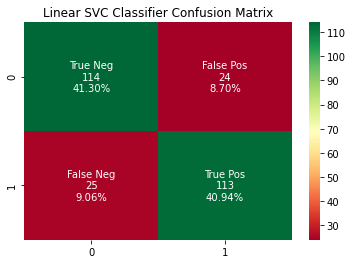

Your accuracy for Random Forest is: 0.8260869565217391


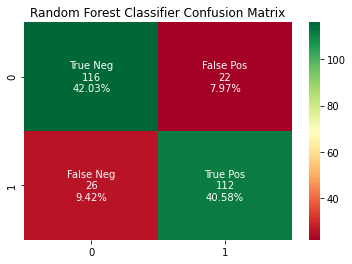

In [6]:
test = sentiment_analysis_pt2('car-reviews.csv')
test

## Quick Summary



* Naive Bayes algorithm worked the best with count vectorizer and smaller maximum feature size since the dimention of the data is quite big. 

* NB assumes conditional likelyhoods of the train dataset is the same with test dataset which might also be an issue when test data is randomly selected. 


* Tf-idf vectorizer worked the best with Random Forest, although Linear SVC also gave comparable results. 


* Among all 3 algorithms, Random Forest still gave the best results, although I am not quite satisfied with the accuracy.

* For better results, I would use Random Forest Regressor and GridSearch to find the best hyperparameters for the dataset after changing the Sentiment to integer values or feed the model with more data especially for Random Forest since it might take some time to train the model.



